# Import Libraries

In [1]:
!pip -q install vit-pytorch
!pip -q install vit_pytorch linformer
!pip -q install timm

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, recall_score, confusion_matrix
from transformers import ViTImageProcessor, ViTForImageClassification, ConvNextV2ForImageClassification, ResNetForImageClassification, MobileNetV2ForImageClassification
from vit_pytorch.efficient import ViT
import timm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(f"Torch: {torch.__version__}")

Torch: 2.0.0


# **Initial training settings**

In [44]:
# Training settings
batch_size = 8
epochs = 10
lr = 10e-5
gamma = 0.7
seed = 42

In [45]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# **Image Augmentation**

In [47]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        #transforms.RandomRotation(degrees=30),
        transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),  # Add vertical flip
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Add color jitter
        #transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # Add random affine transformation
        #transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),  # Add random perspective

        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

# **Load Datasets and Make Dataloader**

In [48]:
train_dir = '/kaggle/input/skin-lesion/Images/train'
test_dir = '/kaggle/input/skin-lesion/Images/test'

all_classes = os.listdir(train_dir)

selected_classes = sorted(
    [
      'actinic keratosis',
      'basal cell carcinoma',
      'dermatofibroma',
      #'lichenoid keratosis',
      'melanoma',
      'nevus',
      'seborrheic keratosis',
      #'solar lentigo',
      'squamous cell carcinoma',
      'vascular lesion'
    ])

selected_class_directories = [os.path.join(train_dir, cl) for cl in selected_classes]
selected_class_directories_test = [os.path.join(test_dir, cl) for cl in selected_classes]

# giving index to each class
class_mapping = {cl: idx for idx, cl in enumerate(selected_classes)}


# prepare train dataset
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)

train_data.samples = [(image, class_mapping[os.path.basename(os.path.dirname(image))]) for image, _ in train_data.samples if os.path.dirname(image) in selected_class_directories]
train_data.imgs = train_data.samples  
train_data.targets = [class_mapping[os.path.basename(os.path.dirname(image))] for image, _ in sorted(train_data.samples, key=lambda x: os.path.basename(os.path.dirname(x[0])))]
train_data.classes = selected_classes

# increase image amount

duplication_factor = {
    'actinic keratosis': 24,
    'basal cell carcinoma': 4,
    'dermatofibroma': 24,
    #'lichenoid keratosis',
    'melanoma': 5,
    'nevus': 2,
    'seborrheic keratosis': 24,
    #'solar lentigo',
    'squamous cell carcinoma': 9,
    'vascular lesion': 24
}

# Increasing amount of images for selected classes
for class_dir in selected_class_directories:
    class_name = os.path.basename(class_dir)
    if class_name in duplication_factor:
        images = [img for img in os.listdir(class_dir)]
        for image in images:
            image_path = os.path.join(class_dir, image)
            for _ in range(duplication_factor[class_name]):
                train_data.samples.append((image_path, class_mapping[class_name]))
                train_data.imgs = train_data.samples
                train_data.targets.append(class_mapping[class_name])

# prepare test dataset
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

test_data.samples = [(image, class_mapping[os.path.basename(os.path.dirname(image))]) for image, _ in test_data.samples if os.path.dirname(image) in selected_class_directories_test]
test_data.imgs = test_data.samples  
test_data.targets = [class_mapping[os.path.basename(os.path.dirname(image))] for image, _ in sorted(test_data.samples, key=lambda x: os.path.basename(os.path.dirname(x[0])))]
test_data.classes = selected_class_directories_test

# Print the number of selected classes and images
print("Train :")
print(f"Selected classes: {train_data.classes}")
print(f"Number of selected classes: {len(train_data.classes)}")
print(f"Number of images in the custom dataset: {len(train_data)}")

# Print the number of selected classes and images
print("Test :")
print(f"Selected classes: {test_data.classes}")
print(f"Number of selected classes: {len(test_data.classes)}")
print(f"Number of images in the custom dataset: {len(test_data)}")

Train :
Selected classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Number of selected classes: 8
Number of images in the custom dataset: 10072
Test :
Selected classes: ['/kaggle/input/skin-lesion/Images/test/actinic keratosis', '/kaggle/input/skin-lesion/Images/test/basal cell carcinoma', '/kaggle/input/skin-lesion/Images/test/dermatofibroma', '/kaggle/input/skin-lesion/Images/test/melanoma', '/kaggle/input/skin-lesion/Images/test/nevus', '/kaggle/input/skin-lesion/Images/test/seborrheic keratosis', '/kaggle/input/skin-lesion/Images/test/squamous cell carcinoma', '/kaggle/input/skin-lesion/Images/test/vascular lesion']
Number of selected classes: 8
Number of images in the custom dataset: 323


In [49]:
# data loader
num_workers = os.cpu_count()

class_names = train_data.classes

train_loader = DataLoader( train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader( test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [50]:
len(train_loader), len(train_data)

(1259, 10072)

# **Visualize image augmentation**

In [40]:
# Assuming you have a DataLoader object named 'train_loader'
for batch_idx, (data, target) in enumerate(train_loader):
    # 'data' is the input data (images), and 'target' is the corresponding labels
    print(f"Batch {batch_idx + 1}:")
    print(f"Data shape: {data.shape}")
    print(f"Target shape: {target.shape}")
    
    # Add any additional details or analysis you need here

    # Break the loop if you want to inspect only the first batch
    """
    if batch_idx == 0:
        break"""

Batch 1:
Data shape: torch.Size([8, 3, 224, 224])
Target shape: torch.Size([8])
Batch 2:
Data shape: torch.Size([8, 3, 224, 224])
Target shape: torch.Size([8])
Batch 3:
Data shape: torch.Size([8, 3, 224, 224])
Target shape: torch.Size([8])
Batch 4:
Data shape: torch.Size([8, 3, 224, 224])
Target shape: torch.Size([8])
Batch 5:
Data shape: torch.Size([8, 3, 224, 224])
Target shape: torch.Size([8])
Batch 6:
Data shape: torch.Size([8, 3, 224, 224])
Target shape: torch.Size([8])
Batch 7:
Data shape: torch.Size([8, 3, 224, 224])
Target shape: torch.Size([8])
Batch 8:
Data shape: torch.Size([8, 3, 224, 224])
Target shape: torch.Size([8])
Batch 9:
Data shape: torch.Size([8, 3, 224, 224])
Target shape: torch.Size([8])
Batch 10:
Data shape: torch.Size([8, 3, 224, 224])
Target shape: torch.Size([8])
Batch 11:
Data shape: torch.Size([8, 3, 224, 224])
Target shape: torch.Size([8])


KeyboardInterrupt: 

In [ ]:
"""
for images, labels in enumerate(train_loader):
    print(labels)
"""    

In [ ]:
# Get a batch of data
for images, labels in train_loader:
    # Convert images to numpy for display
    images_np = images.numpy()

    # Display the images
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(6):
        ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images_np[idx], (1, 2, 0)))
        ax.set_title(class_names[labels[idx]])
    plt.show()

    # Break the loop if you only want to display one batch
    #break

# **Amount of images in each class of Train data**

In [51]:
# Count the number of images for each class
class_counts = {class_name: 0 for class_name in class_names}

for _, labels in train_loader:
    for label in labels:
        label = label.item()  
        class_name = class_names[label]
        class_counts[class_name] += 1

classes = list(class_counts.keys())
counts = list(class_counts.values())

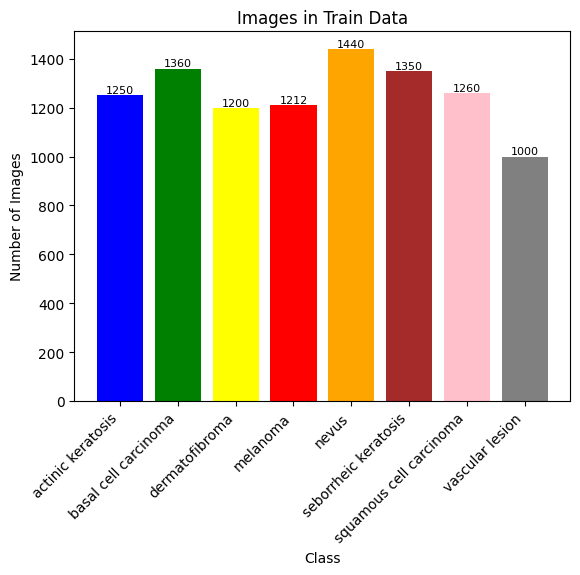

In [52]:
# Create a bar graph
class_colors = ['blue', 'green', 'yellow', 'red', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

fig, ax = plt.subplots()
bars = ax.bar(classes, counts, color=class_colors)

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Images in Train Data')

# Add count labels on top of the bars
for bar, count in zip(bars, counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(count), ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.show()

# **After augmentation : Amount of images in each class of Train data**

In [ ]:
# Count the number of images for each class
class_counts = {class_name: 0 for class_name in class_names}

for _, labels in train_loader:
    for label in labels:
        label = label.item()  
        class_name = class_names[label]
        class_counts[class_name] += 1

classes = list(class_counts.keys())
counts = list(class_counts.values())


# Create a bar graph
class_colors = ['blue', 'green', 'yellow', 'red', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

fig, ax = plt.subplots()
bars = ax.bar(classes, counts, color=class_colors)

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('After Augmentation : Images in Train Data ')

# Add count labels on top of the bars
for bar, count in zip(bars, counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(count), ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.show()

# **Amount of images in test dataset**

In [ ]:
# Count the number of images for each class
class_counts = {class_name: 0 for class_name in class_names}

for _, labels in test_loader:
    for label in labels:
        label = label.item()  
        class_name = class_names[label]
        class_counts[class_name] += 1

classes = list(class_counts.keys())
counts = list(class_counts.values())


# Create a bar graph
class_colors = ['blue', 'green', 'yellow', 'red', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

fig, ax = plt.subplots()
bars = ax.bar(classes, counts, color=class_colors)

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Images in Test Data')

# Add count labels on top of the bars
for bar, count in zip(bars, counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(count), ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.show()

# **Weights for each class**

In [ ]:
# Calculate class weights
class_weights = [1.0 / count for count in class_counts.values()]
print(class_weights)

# **Untrained Vision Transformer model**

In [ ]:
from vit_pytorch import ViT
model_untrained_vit = ViT(
    image_size = 224,
    patch_size = 16,
    channels = 3,
    num_classes = 10,
    dim = 768,
    depth = 12,
    heads = 16,
    mlp_dim = 3072,
    dropout = 0.1,
    emb_dropout = 0.1
)

model_untrained_vit = model_untrained_vit.to(device)

# **Training on untrained ViT**

In [ ]:
# training

train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_untrained_vit.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Get logits from the model output
        output = model_untrained_vit(data)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    train_accuracy_list.append(epoch_accuracy.item())
    train_loss_list.append(epoch_loss.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model_untrained_vit(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)
            
        val_accuracy_list.append(epoch_val_accuracy.item())
        val_loss_list.append(epoch_val_loss.item())

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

# **Testing on untrained ViT**

In [ ]:
# Testing 

model_untrained_vit.eval()

total_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)

        output = model_untrained_vit(data)
        loss = criterion(output, label)

        total_loss += loss.item()

        predictions = output.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy().tolist())
        all_labels.extend(label.cpu().numpy().tolist())

avg_loss = total_loss / len(test_loader)


# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

In [ ]:
# Plotting the training and validation loss curves
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')

plt.title('Training and Validation Loss over Epochs'
          '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy_list)
plt.plot(val_accuracy_list)

plt.title("Model Accuracy"
         '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()



# Calculate recall
overall_recall = recall_score(all_labels, all_predictions, average=None)
#print(f"Overall Test Recall: {overall_recall:}")

# Bar chart
plt.figure(figsize=(7, 6))
bars = plt.barh(class_names, overall_recall, color='blue')

# Displaying accuracy values on the bars
for bar, acc in zip(bars, overall_recall):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{acc:.4f}', ha='left', va='center')

plt.xlabel('Recall')
plt.ylabel('Class')
plt.title('Test Dataset \n Recall : epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}')
plt.xlim(0, 1)  # Set x-axis limit from 0 to 1
plt.show()



# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


"""
# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions))
"""

# **Apply Pre-trained ViT**

In [ ]:
all_ViT_pretrained_models = timm.list_models('beit*', pretrained=True)
all_ViT_pretrained_models

# **Apply :** vit_base_patch16_224.augreg2_in21k_ft_in1k

In [ ]:
model_vit_b_16_224_augreg2_in21k_ft_in1k = timm.create_model('vit_base_patch16_224.augreg2_in21k_ft_in1k', pretrained = True, num_classes = 10)
model_vit_b_16_224_augreg2_in21k_ft_in1k = model_vit_b_16_224_augreg2_in21k_ft_in1k.to(device)

In [ ]:
# model info
model_vit_b_16_224_augreg2_in21k_ft_in1k.default_cfg

In [ ]:
# check class numbers
model_vit_b_16_224_augreg2_in21k_ft_in1k.get_classifier()

In [ ]:
# training

train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_vit_b_16_224_augreg2_in21k_ft_in1k.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Get logits from the model output
        output = model_vit_b_16_224_augreg2_in21k_ft_in1k(data)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    train_accuracy_list.append(epoch_accuracy.item())
    train_loss_list.append(epoch_loss.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model_vit_b_16_224_augreg2_in21k_ft_in1k(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)
            
        val_accuracy_list.append(epoch_val_accuracy.item())
        val_loss_list.append(epoch_val_loss.item())

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
# Testing 

model_vit_b_16_224_augreg2_in21k_ft_in1k.eval()

total_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)

        output = model_vit_b_16_224_augreg2_in21k_ft_in1k(data)
        loss = criterion(output, label)

        total_loss += loss.item()

        predictions = output.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy().tolist())
        all_labels.extend(label.cpu().numpy().tolist())

avg_loss = total_loss / len(test_loader)


# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

In [ ]:
# Plotting the training and validation loss curves
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')

plt.title('Training and Validation Loss over Epochs'
          '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy_list)
plt.plot(val_accuracy_list)

plt.title("Model Accuracy"
         '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()



# Calculate recall
overall_recall = recall_score(all_labels, all_predictions, average=None)
#print(f"Overall Test Recall: {overall_recall:}")

# Bar chart
plt.figure(figsize=(7, 6))
bars = plt.barh(class_names, overall_recall, color='blue')

# Displaying accuracy values on the bars
for bar, acc in zip(bars, overall_recall):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{acc:.4f}', ha='left', va='center')

plt.xlabel('Recall')
plt.ylabel('Class')
plt.title('Test Dataset \n Recall : epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}')
plt.xlim(0, 1)  # Set x-axis limit from 0 to 1
plt.show()



# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


"""
# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions))
"""

# **Apply :** google/vit-base-patch16-224

In [54]:
model_google_vit_base_patch16_224 = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model_google_vit_base_patch16_224.config.num_labels = 8
model_google_vit_base_patch16_224.classifier = nn.Linear(
    in_features=model_google_vit_base_patch16_224.config.hidden_size, 
    out_features=8)
model_google_vit_base_patch16_224 = model_google_vit_base_patch16_224.to(device)

In [55]:
# training

train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_google_vit_base_patch16_224.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Get logits from the model output
        output = model_google_vit_base_patch16_224(data).logits

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    train_accuracy_list.append(epoch_accuracy.item())
    train_loss_list.append(epoch_loss.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model_google_vit_base_patch16_224(data).logits 
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)
            
        val_accuracy_list.append(epoch_val_accuracy.item())
        val_loss_list.append(epoch_val_loss.item())

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/1259 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.2266 - acc: 0.5383 - val_loss : 1.1713 - val_acc: 0.6047



  0%|          | 0/1259 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.7124 - acc: 0.7452 - val_loss : 1.3184 - val_acc: 0.6352



  0%|          | 0/1259 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.5310 - acc: 0.8172 - val_loss : 1.2820 - val_acc: 0.6382



  0%|          | 0/1259 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.4462 - acc: 0.8458 - val_loss : 1.4324 - val_acc: 0.6657



  0%|          | 0/1259 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.4000 - acc: 0.8599 - val_loss : 1.3123 - val_acc: 0.6931



  0%|          | 0/1259 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.3277 - acc: 0.8892 - val_loss : 1.4947 - val_acc: 0.6606



  0%|          | 0/1259 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.3103 - acc: 0.8944 - val_loss : 1.5163 - val_acc: 0.6900



  0%|          | 0/1259 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.2878 - acc: 0.9023 - val_loss : 1.6010 - val_acc: 0.6972



  0%|          | 0/1259 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.2859 - acc: 0.9004 - val_loss : 1.4181 - val_acc: 0.6961



  0%|          | 0/1259 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.2708 - acc: 0.9073 - val_loss : 1.6445 - val_acc: 0.6474



In [ ]:
# Testing 

model_google_vit_base_patch16_224.eval()

total_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)

        output = model_google_vit_base_patch16_224(data).logits
        loss = criterion(output, label)

        total_loss += loss.item()

        predictions = output.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy().tolist())
        all_labels.extend(label.cpu().numpy().tolist())

avg_loss = total_loss / len(test_loader)


# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

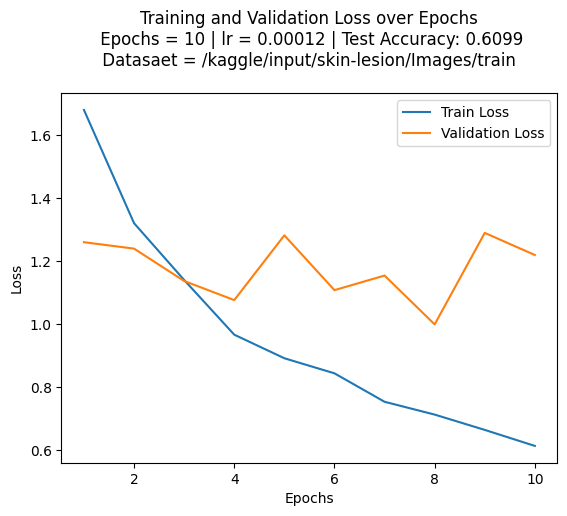

In [34]:
# Plotting the training and validation loss curves
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')

plt.title('Training and Validation Loss over Epochs'
          '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

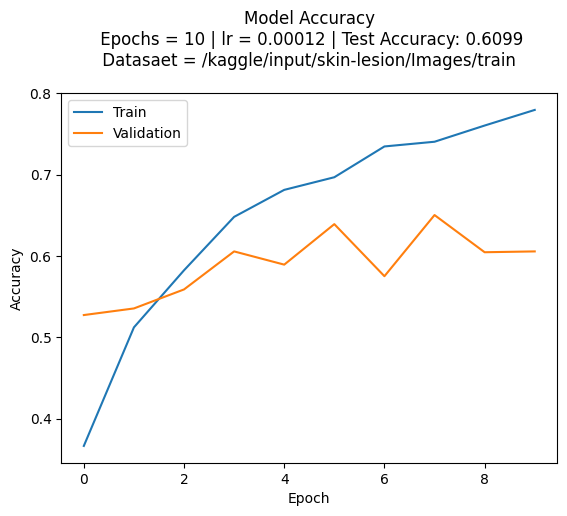

In [36]:
plt.plot(train_accuracy_list)
plt.plot(val_accuracy_list)

plt.title("Model Accuracy"
         '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

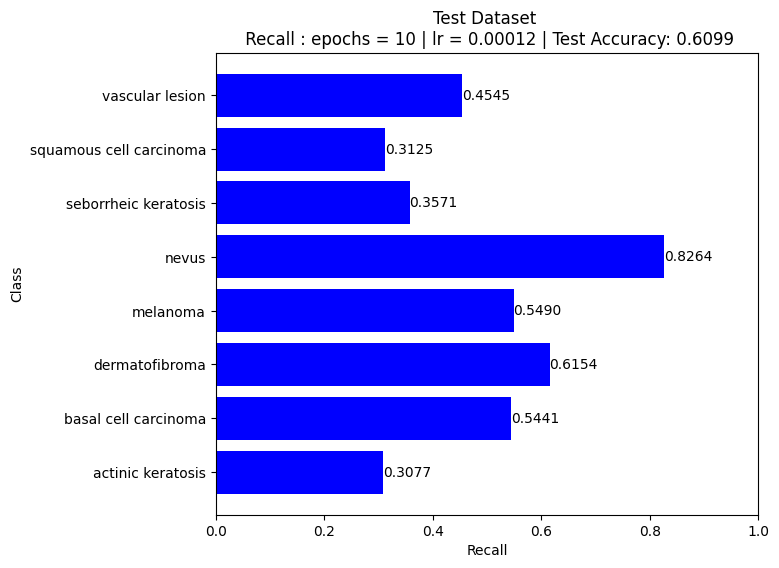

In [37]:
# Calculate recall
overall_recall = recall_score(all_labels, all_predictions, average=None)
#print(f"Overall Test Recall: {overall_recall:}")

# Bar chart
plt.figure(figsize=(7, 6))
bars = plt.barh(class_names, overall_recall, color='blue')

# Displaying accuracy values on the bars
for bar, acc in zip(bars, overall_recall):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{acc:.4f}', ha='left', va='center')

plt.xlabel('Recall')
plt.ylabel('Class')
plt.title('Test Dataset \n Recall : epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}')
plt.xlim(0, 1)  # Set x-axis limit from 0 to 1
plt.show()

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions))

In [ ]:
# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# **Apply :** Large google/vit-large-patch16-224

In [ ]:
model_google_vit_large_patch16_224 = ViTForImageClassification.from_pretrained('google/vit-large-patch16-224')
model_google_vit_large_patch16_224.config.num_labels = 10
model_google_vit_large_patch16_224.classifier = nn.Linear(in_features=model_google_vit_large_patch16_224.config.hidden_size, 
                                                          out_features=10)
model_google_vit_large_patch16_224 = model_google_vit_large_patch16_224.to(device)

# training

train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_google_vit_large_patch16_224.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Get logits from the model output
        output = model_google_vit_large_patch16_224(data).logits

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    train_accuracy_list.append(epoch_accuracy.item())
    train_loss_list.append(epoch_loss.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model_google_vit_large_patch16_224(data).logits
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)
            
        val_accuracy_list.append(epoch_val_accuracy.item())
        val_loss_list.append(epoch_val_loss.item())

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
# Testing 

model_google_vit_large_patch16_224.eval()

total_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)

        output = model_google_vit_large_patch16_224(data).logits
        loss = criterion(output, label)

        total_loss += loss.item()

        predictions = output.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy().tolist())
        all_labels.extend(label.cpu().numpy().tolist())

avg_loss = total_loss / len(test_loader)


# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

In [ ]:
# Plotting the training and validation loss curves
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')

plt.title('Training and Validation Loss over Epochs'
          '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy_list)
plt.plot(val_accuracy_list)

plt.title("Model Accuracy"
         '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [ ]:
# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# **Apply :** BEiT 

In [ ]:
from transformers import BeitConfig, BeitModel

In [ ]:
# Initializing a BEiT beit-base-patch16-224-pt22k style configuration
configuration = BeitConfig()

# Set the number of labels to 10
configuration.num_labels = 10

# Initializing a model (with random weights) from the beit-base-patch16-224-pt22k style configuration
model_Beit = BeitModel(configuration)

# Accessing the model configuration
configuration = model_Beit.config 


# Modify the classification head for 10 classes
model_Beit.cls_head = nn.Linear(model_Beit.config.hidden_size, configuration.num_labels)


model_Beit = model_Beit.to(device)
print(configuration)

In [ ]:
# training

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_Beit.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Get logits from the model output
        output = model_Beit(data).last_hidden_state

        # Apply pooling or other necessary operations to obtain logits
        output = output.mean(dim=1)

        # Make sure the target has the correct shape
        label = label.view(-1)  # Flatten the label tensor to shape [batch_size]

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)



    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} \n"
    )

In [ ]:
# Testing 

model_Beit.eval()

total_accuracy = 0
total_loss = 0

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)

        # Get logits from the model output
        output = model_Beit(data).last_hidden_state

        # Apply pooling or other necessary operations to obtain logits
        output = output.mean(dim=1)
                
        # Make sure the target has the correct shape
        label = label.view(-1)  # Flatten the label tensor to shape [batch_size]

        loss = criterion(output, label)

        acc = (output.argmax(dim=1) == label).float().mean()
        total_accuracy += acc.item()
        total_loss += loss.item()

avg_accuracy = total_accuracy / len(test_loader)
avg_loss = total_loss / len(test_loader)

print(f"Test Accuracy: {avg_accuracy:.4f}")
print(f"Test Loss: {avg_loss:.4f}")

# **Apply :** Dinov2

In [ ]:
from transformers import Dinov2Config, Dinov2Model

In [ ]:
# Initializing a Dinov2 dinov2-base-patch16-224 style configuration
configuration = Dinov2Config()

configuration.num_labels = 10

# Initializing a model (with random weights) from the dinov2-base-patch16-224 style configuration
model_Dinov2 = Dinov2Model(configuration)

# Accessing the model configuration
configuration = model_Dinov2.config

# Modify the classification head for 10 classes
model_Dinov2.cls_head = nn.Linear(model_Dinov2.config.hidden_size, configuration.num_labels)

model_Dinov2 = model_Dinov2.to(device)

print(configuration)

In [ ]:
# training

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_Dinov2.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Get logits from the model output
        output = model_Dinov2(data).last_hidden_state

        # Apply pooling or other necessary operations to obtain logits
        output = output.mean(dim=1)

        # Make sure the target has the correct shape
        label = label.view(-1)  # Flatten the label tensor to shape [batch_size]

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)



    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} \n"
    )

# **Apply :** KhalfounMehdi/dermatology_vit

In [ ]:
model_KhalfounMehdi_dermatology_vit = ViTForImageClassification.from_pretrained('KhalfounMehdi/dermatology_vit')
model_KhalfounMehdi_dermatology_vit.config.num_labels = 10
model_KhalfounMehdi_dermatology_vit.classifier = nn.Linear(in_features=model_KhalfounMehdi_dermatology_vit.config.hidden_size, out_features=10)
model_KhalfounMehdi_dermatology_vit = model_KhalfounMehdi_dermatology_vit.to(device)

In [ ]:
# training

train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_KhalfounMehdi_dermatology_vit.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Get logits from the model output
        output = model_KhalfounMehdi_dermatology_vit(data).logits

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    train_accuracy_list.append(epoch_accuracy.item())
    train_loss_list.append(epoch_loss.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model_KhalfounMehdi_dermatology_vit(data).logits
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)
            
        val_accuracy_list.append(epoch_val_accuracy.item())
        val_loss_list.append(epoch_val_loss.item())

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
# Testing 

model_KhalfounMehdi_dermatology_vit.eval()

total_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)

        output = model_KhalfounMehdi_dermatology_vit(data).logits
        loss = criterion(output, label)

        total_loss += loss.item()

        predictions = output.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy().tolist())
        all_labels.extend(label.cpu().numpy().tolist())

avg_loss = total_loss / len(test_loader)


# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

In [ ]:
# Plotting the training and validation loss curves
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')

plt.title('Training and Validation Loss over Epochs'
          '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy_list)
plt.plot(val_accuracy_list)

plt.title("Model Accuracy"
         '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()



# Calculate recall
overall_recall = recall_score(all_labels, all_predictions, average=None)
#print(f"Overall Test Recall: {overall_recall:}")

# Bar chart
plt.figure(figsize=(7, 6))
bars = plt.barh(class_names, overall_recall, color='blue')

# Displaying accuracy values on the bars
for bar, acc in zip(bars, overall_recall):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{acc:.4f}', ha='left', va='center')

plt.xlabel('Recall')
plt.ylabel('Class')
plt.title('Test Dataset \n Recall : epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}')
plt.xlim(0, 1)  # Set x-axis limit from 0 to 1
plt.show()



# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


"""
# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions))
"""

# **Apply :** facebook/convnextv2-tiny-1k-224

In [ ]:
model_facebook_convnextv2_tiny_1k_224 = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-tiny-1k-224")
model_facebook_convnextv2_tiny_1k_224.config.num_labels = 10
model_facebook_convnextv2_tiny_1k_224 = model_facebook_convnextv2_tiny_1k_224.to(device)

In [ ]:
# training

train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_facebook_convnextv2_tiny_1k_224.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Get logits from the model output
        output = model_facebook_convnextv2_tiny_1k_224(data).logits

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    train_accuracy_list.append(epoch_accuracy.item())
    train_loss_list.append(epoch_loss.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model_facebook_convnextv2_tiny_1k_224(data).logits
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)
            
        val_accuracy_list.append(epoch_val_accuracy.item())
        val_loss_list.append(epoch_val_loss.item())

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
# Testing 

model_facebook_convnextv2_tiny_1k_224.eval()

total_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)

        output = model_facebook_convnextv2_tiny_1k_224(data).logits
        loss = criterion(output, label)

        total_loss += loss.item()

        predictions = output.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy().tolist())
        all_labels.extend(label.cpu().numpy().tolist())

avg_loss = total_loss / len(test_loader)


# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

In [ ]:
# Plotting the training and validation loss curves
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')

plt.title('Training and Validation Loss over Epochs'
          '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy_list)
plt.plot(val_accuracy_list)

plt.title("Model Accuracy"
         '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()



# Calculate recall
overall_recall = recall_score(all_labels, all_predictions, average=None)
#print(f"Overall Test Recall: {overall_recall:}")

# Bar chart
plt.figure(figsize=(7, 6))
bars = plt.barh(class_names, overall_recall, color='blue')

# Displaying accuracy values on the bars
for bar, acc in zip(bars, overall_recall):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{acc:.4f}', ha='left', va='center')

plt.xlabel('Recall')
plt.ylabel('Class')
plt.title('Test Dataset \n Recall : epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}')
plt.xlim(0, 1)  # Set x-axis limit from 0 to 1
plt.show()



# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


"""
# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions))
"""

# **Apply :** facebook/deit-tiny-patch16-224

In [ ]:
model_facebook_deit_tiny_patch16_224 = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224')
model_facebook_deit_tiny_patch16_224.config.num_labels = 10
model_facebook_deit_tiny_patch16_224.classifier = nn.Linear(in_features=model_facebook_deit_tiny_patch16_224.config.hidden_size, 
                                                            out_features=10)
model_facebook_deit_tiny_patch16_224 = model_facebook_deit_tiny_patch16_224.to(device)

In [ ]:
# training

train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_facebook_deit_tiny_patch16_224.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Get logits from the model output
        output = model_facebook_deit_tiny_patch16_224(data).logits

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    train_accuracy_list.append(epoch_accuracy.item())
    train_loss_list.append(epoch_loss.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model_facebook_deit_tiny_patch16_224(data).logits
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)
            
        val_accuracy_list.append(epoch_val_accuracy.item())
        val_loss_list.append(epoch_val_loss.item())

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
# Testing 

model_facebook_deit_tiny_patch16_224.eval()

total_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)

        output = model_facebook_deit_tiny_patch16_224(data).logits
        loss = criterion(output, label)

        total_loss += loss.item()

        predictions = output.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy().tolist())
        all_labels.extend(label.cpu().numpy().tolist())

avg_loss = total_loss / len(test_loader)


# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

In [ ]:
# Plotting the training and validation loss curves
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')

plt.title('Training and Validation Loss over Epochs'
          '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy_list)
plt.plot(val_accuracy_list)

plt.title("Model Accuracy"
         '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()



# Calculate recall
overall_recall = recall_score(all_labels, all_predictions, average=None)
#print(f"Overall Test Recall: {overall_recall:}")

# Bar chart
plt.figure(figsize=(7, 6))
bars = plt.barh(class_names, overall_recall, color='blue')

# Displaying accuracy values on the bars
for bar, acc in zip(bars, overall_recall):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{acc:.4f}', ha='left', va='center')

plt.xlabel('Recall')
plt.ylabel('Class')
plt.title('Test Dataset \n Recall : epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}')
plt.xlim(0, 1)  # Set x-axis limit from 0 to 1
plt.show()



# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


"""
# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions))
"""

# **Apply :** microsoft/resnet-50

In [ ]:
model_microsoft_resnet_50 = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
model_microsoft_resnet_50.config.num_labels = 10
model_microsoft_resnet_50 = model_microsoft_resnet_50.to(device)

In [ ]:
# training

train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_microsoft_resnet_50.parameters(), lr=9e-5)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Get logits from the model output
        output = model_microsoft_resnet_50(data).logits

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    train_accuracy_list.append(epoch_accuracy.item())
    train_loss_list.append(epoch_loss.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model_microsoft_resnet_50(data).logits
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)
            
        val_accuracy_list.append(epoch_val_accuracy.item())
        val_loss_list.append(epoch_val_loss.item())

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
# Testing 

model_microsoft_resnet_50.eval()

total_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)

        output = model_microsoft_resnet_50(data).logits
        loss = criterion(output, label)

        total_loss += loss.item()

        predictions = output.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy().tolist())
        all_labels.extend(label.cpu().numpy().tolist())

avg_loss = total_loss / len(test_loader)


# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

In [ ]:
# Plotting the training and validation loss curves
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')

plt.title('Training and Validation Loss over Epochs'
          '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy_list)
plt.plot(val_accuracy_list)

plt.title("Model Accuracy"
         '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()



# Calculate recall
overall_recall = recall_score(all_labels, all_predictions, average=None)
#print(f"Overall Test Recall: {overall_recall:}")

# Bar chart
plt.figure(figsize=(7, 6))
bars = plt.barh(class_names, overall_recall, color='blue')

# Displaying accuracy values on the bars
for bar, acc in zip(bars, overall_recall):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{acc:.4f}', ha='left', va='center')

plt.xlabel('Recall')
plt.ylabel('Class')
plt.title('Test Dataset \n Recall : epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}')
plt.xlim(0, 1)  # Set x-axis limit from 0 to 1
plt.show()



# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


"""
# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions))
"""

# **Apply :** google/mobilenet_v2_1.0_224

In [ ]:
model_google_mobilenet_v2_1_0_224 = MobileNetV2ForImageClassification.from_pretrained("google/mobilenet_v2_1.0_224")
model_google_mobilenet_v2_1_0_224.config.num_labels = 10
model_google_mobilenet_v2_1_0_224 = model_google_mobilenet_v2_1_0_224.to(device)

In [ ]:
# training

train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_google_mobilenet_v2_1_0_224.parameters(), lr=10e-5)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Get logits from the model output
        output = model_google_mobilenet_v2_1_0_224(data).logits

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    train_accuracy_list.append(epoch_accuracy.item())
    train_loss_list.append(epoch_loss.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model_google_mobilenet_v2_1_0_224(data).logits
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)
            
        val_accuracy_list.append(epoch_val_accuracy.item())
        val_loss_list.append(epoch_val_loss.item())

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
# Testing 

model_google_mobilenet_v2_1_0_224.eval()

total_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)

        output = model_google_mobilenet_v2_1_0_224(data).logits
        loss = criterion(output, label)

        total_loss += loss.item()

        predictions = output.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy().tolist())
        all_labels.extend(label.cpu().numpy().tolist())

avg_loss = total_loss / len(test_loader)


# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

In [ ]:
# Plotting the training and validation loss curves
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')

plt.title('Training and Validation Loss over Epochs'
          '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy_list)
plt.plot(val_accuracy_list)

plt.title("Model Accuracy"
         '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()



# Calculate recall
overall_recall = recall_score(all_labels, all_predictions, average=None)
#print(f"Overall Test Recall: {overall_recall:}")

# Bar chart
plt.figure(figsize=(7, 6))
bars = plt.barh(class_names, overall_recall, color='blue')

# Displaying accuracy values on the bars
for bar, acc in zip(bars, overall_recall):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{acc:.4f}', ha='left', va='center')

plt.xlabel('Recall')
plt.ylabel('Class')
plt.title('Test Dataset \n Recall : epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}')
plt.xlim(0, 1)  # Set x-axis limit from 0 to 1
plt.show()



# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


"""
# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions))
"""

# **Apply :** timm/vit_large_patch14_clip_224.openai_ft_in1k

In [ ]:
model_timm_vit_large_patch14_clip_224_openai_ft_in1k = timm.create_model('timm/vit_large_patch14_clip_224.openai_ft_in1k', 
                                                                         pretrained = True, 
                                                                         num_classes = 10)
model_timm_vit_large_patch14_clip_224_openai_ft_in1k = model_timm_vit_large_patch14_clip_224_openai_ft_in1k.to(device)

In [ ]:
# training

train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_timm_vit_large_patch14_clip_224_openai_ft_in1k.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Get logits from the model output
        output = model_timm_vit_large_patch14_clip_224_openai_ft_in1k(data)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    train_accuracy_list.append(epoch_accuracy.item())
    train_loss_list.append(epoch_loss.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model_timm_vit_large_patch14_clip_224_openai_ft_in1k(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)
            
        val_accuracy_list.append(epoch_val_accuracy.item())
        val_loss_list.append(epoch_val_loss.item())

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
# Testing 

model_timm_vit_large_patch14_clip_224_openai_ft_in1k.eval()

total_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)

        output = model_timm_vit_large_patch14_clip_224_openai_ft_in1k(data)
        loss = criterion(output, label)

        total_loss += loss.item()

        predictions = output.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy().tolist())
        all_labels.extend(label.cpu().numpy().tolist())

avg_loss = total_loss / len(test_loader)


# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

In [ ]:
# Plotting the training and validation loss curves
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')

plt.title('Training and Validation Loss over Epochs'
          '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy_list)
plt.plot(val_accuracy_list)

plt.title("Model Accuracy"
         '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()



# Calculate recall
overall_recall = recall_score(all_labels, all_predictions, average=None)
#print(f"Overall Test Recall: {overall_recall:}")

# Bar chart
plt.figure(figsize=(7, 6))
bars = plt.barh(class_names, overall_recall, color='blue')

# Displaying accuracy values on the bars
for bar, acc in zip(bars, overall_recall):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{acc:.4f}', ha='left', va='center')

plt.xlabel('Recall')
plt.ylabel('Class')
plt.title('Test Dataset \n Recall : epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}')
plt.xlim(0, 1)  # Set x-axis limit from 0 to 1
plt.show()



# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


"""
# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions))
"""

# **Apply :** beitv2_large_patch16_224.in1k_ft_in22k_in1k *[ memory prob ]*

In [ ]:
model_beitv2_large_patch16_224_in1k_ft_in22k_in1k = timm.create_model('beitv2_large_patch16_224.in1k_ft_in22k_in1k', pretrained = True, num_classes = 10)
model_beitv2_large_patch16_224_in1k_ft_in22k_in1k = model_beitv2_large_patch16_224_in1k_ft_in22k_in1k.to(device)

In [ ]:
# model info
model_beitv2_large_patch16_224_in1k_ft_in22k_in1k.default_cfg

In [ ]:
# check class numbers
model_beitv2_large_patch16_224_in1k_ft_in22k_in1k.get_classifier()

In [ ]:
# training

train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_beitv2_large_patch16_224_in1k_ft_in22k_in1k.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Get logits from the model output
        output = model_beitv2_large_patch16_224_in1k_ft_in22k_in1k(data)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    train_accuracy_list.append(epoch_accuracy.item())
    train_loss_list.append(epoch_loss.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model_beitv2_large_patch16_224_in1k_ft_in22k_in1k(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)
            
        val_accuracy_list.append(epoch_val_accuracy.item())
        val_loss_list.append(epoch_val_loss.item())

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
# Testing 

model_beitv2_large_patch16_224_in1k_ft_in22k_in1k.eval()

total_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)

        output = model_beitv2_large_patch16_224_in1k_ft_in22k_in1k(data).logits
        loss = criterion(output, label)

        total_loss += loss.item()

        predictions = output.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy().tolist())
        all_labels.extend(label.cpu().numpy().tolist())

avg_loss = total_loss / len(test_loader)


# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

In [ ]:
# Plotting the training and validation loss curves
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')

plt.title('Training and Validation Loss over Epochs'
          '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy_list)
plt.plot(val_accuracy_list)

plt.title("Model Accuracy"
         '\n Epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}'
          '\n Datasaet = 'f'{train_dir} ' , pad=20)

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()



# Calculate recall
overall_recall = recall_score(all_labels, all_predictions, average=None)
#print(f"Overall Test Recall: {overall_recall:}")

# Bar chart
plt.figure(figsize=(7, 6))
bars = plt.barh(class_names, overall_recall, color='blue')

# Displaying accuracy values on the bars
for bar, acc in zip(bars, overall_recall):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{acc:.4f}', ha='left', va='center')

plt.xlabel('Recall')
plt.ylabel('Class')
plt.title('Test Dataset \n Recall : epochs = 'f'{epochs} | lr = 'f'{lr} | Test Accuracy: {overall_accuracy:.4f}')
plt.xlim(0, 1)  # Set x-axis limit from 0 to 1
plt.show()



# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


"""
# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions))
"""